In [3]:
#Import packages
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

## The data analysis below uses Airbnb data of San Francisco in March 2018

In [4]:
#Read SF listings from March 2018 csv file to a Pandas DataFrame
url_listing = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/2018_march_listings.csv.gz'
df_listing = pd.read_csv(url_listing, sep=',')

In [5]:
#Read SF listing summary csv into a Pandas DataFrame
url = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/2018_march_listings.csv'
df = pd.read_csv(url, sep=',')

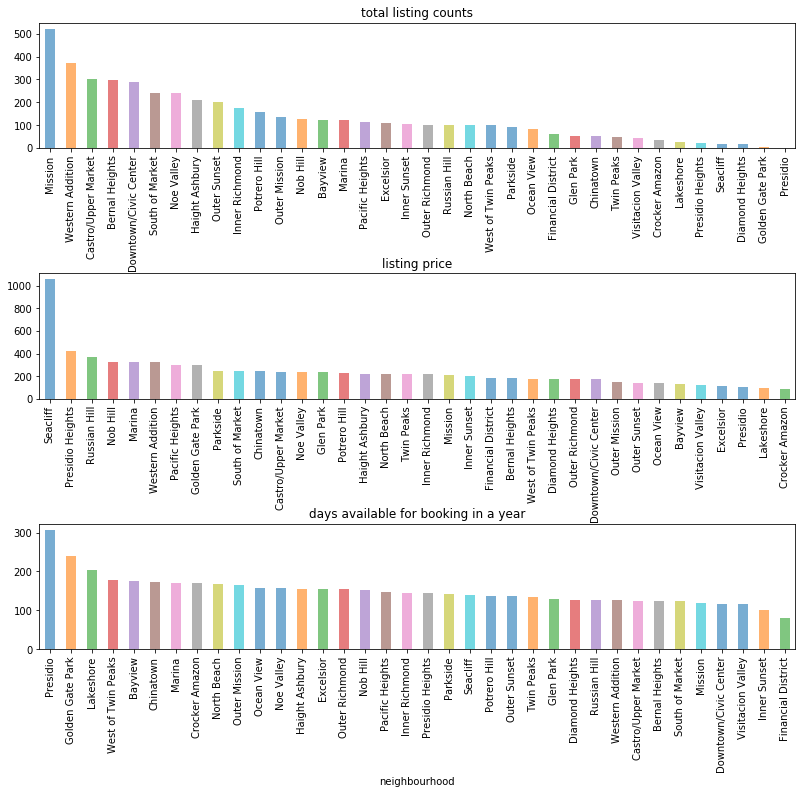

In [6]:
#Count the total listings in each neighbourhood
nh_counts = df['neighbourhood'].value_counts(dropna=False)
plt.subplot(3,1,1)
nh_counts.plot(kind='bar', title='total listing counts', alpha = 0.6, figsize=(12,3))

#Get the average price of listings in each neighbourhood
nh_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
plt.subplot(3,1,2)
nh_price.plot(kind='bar', title = 'listing price', alpha = 0.6, figsize=(12,3))

# This shows the popularity of different neighbourhoods in San Francisco
nh_avail = df.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=False)
plt.subplot(3,1,3)
nh_avail.plot(kind='bar', title = 'days available for booking in a year', alpha = 0.6, figsize=(12,3))

plt.subplots_adjust(left=0.125, bottom=0.1, right=1, top=3, wspace=None, hspace=1)

In [7]:
#Load geodata with geometry information of the neighbourhoods in San Francisco
geo_file = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/neighbourhoods.geojson'
with open(geo_file) as f:
    geodata = json.load(f)
    
#Create a GeoDataFrame from geodata    
nh_gdf = GeoDataFrame.from_features(geodata)

#Delete the empty column 'neighbourhood_group'
del nh_gdf['neighbourhood_group']

#Set the GeoDataFrame's index to 'neighbourhood'
nh_gdf = nh_gdf.set_index('neighbourhood')

In [8]:
#Combine the GeoDataFrame nh_gdf with other neighbourhood dfs.
neighbourhood_gdf = pd.concat([nh_gdf, nh_counts, nh_price, nh_avail], axis=1, join='outer', sort=True)
neighbourhood_gdf = neighbourhood_gdf.dropna(how='any')
neighbourhood_gdf = neighbourhood_gdf.rename(index=str, columns={'neighbourhood':'total listings'})
neighbourhood_gdf.head()

,geometry,total listings,price,availability_365
Bayview,"(POLYGON ((-122.388108 37.747803, -122.3881 37...",123.0,127.284553,175.975610
Bernal Heights,"(POLYGON ((-122.428255 37.731785, -122.428147 ...",299.0,178.662207,123.789298
Castro/Upper Market,"(POLYGON ((-122.446438 37.761036, -122.446408 ...",301.0,238.920266,124.039867
Chinatown,"(POLYGON ((-122.408767 37.790163, -122.408797 ...",51.0,241.686275,172.627451
Crocker Amazon,"(POLYGON ((-122.42085 37.708335, -122.423878 3...",35.0,88.742857,170.685714


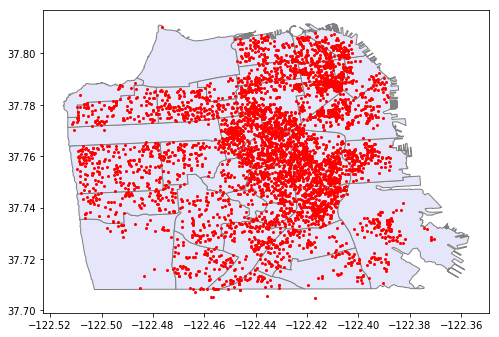

In [9]:
loc = zip(df_listing['longitude'], df_listing['latitude'])
geometry = [Point(xy) for xy in loc]
crs = {'init': 'epsg:4269'}
listing_geo = gpd.GeoDataFrame(df_listing, crs=crs, geometry=geometry)
base = neighbourhood_gdf.plot(color='lavender', edgecolor='grey', figsize=(8,8))
listing_geo.plot(ax=base, marker='o', color='red', markersize = 4)
plt.show()

### The map above shows the location of the Airbnb units in San Francisco. As the maps above show, Airbnb units appear to be concentrated in the northern and eastern neighborhoods of the city.

Text(0.5,1,'Number of listings by neighbourhood')

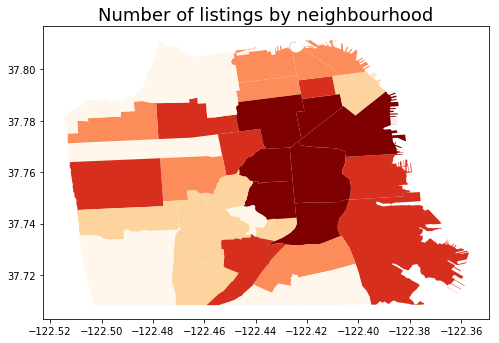

In [10]:
neighbourhood_gdf.plot(column='total listings', cmap='OrRd', figsize=(8,8), scheme='quantiles')
plt.title('Number of listings by neighbourhood', {'fontsize': 18})

### This map demonstrates that most listings are concentrated in core neighborhoods that are close to Market Street.

Text(0.5,1,'Average listing price per night by neighbourhood')

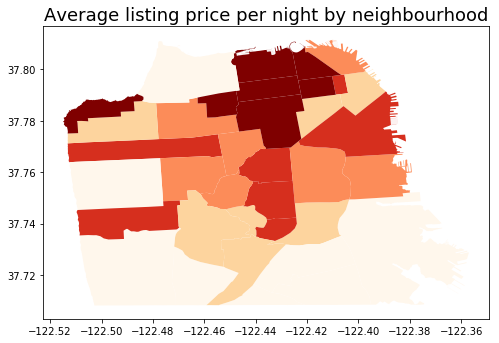

In [11]:
neighbourhood_gdf.plot(column='price', cmap='OrRd', figsize=(8,8), scheme='quantiles')
plt.title('Average listing price per night by neighbourhood', {'fontsize': 18})

### This map shows that most expensive listings are concentrated in north of Market Street and Seacliff area.

Text(0.5,1,'Average days available for booking in one year')

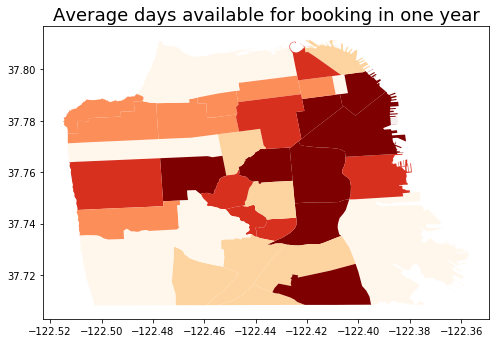

In [12]:
#Use a reverse cmap to indicate the availability_365, because the less available the listing, the more popular it is.
neighbourhood_gdf.plot(column='availability_365', cmap='OrRd_r', figsize=(8,8), scheme='quantiles')
plt.title('Average days available for booking in one year', {'fontsize': 18})

### This map shows that the most popular neighbourhoods are those areas relatively cheap, but still close to the core neighbourhoods around Market Street. The most expensive neighbourhoods are relatively less desirable for a home stay with Airbnb

Text(0,0.5,'Availability in next 365 days [in days]')

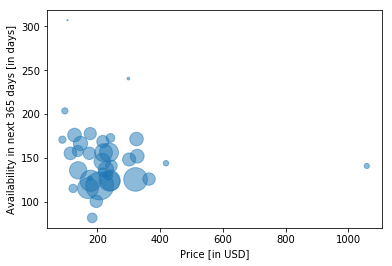

In [13]:
# set s argument
plt.scatter(neighbourhood_gdf['price'], neighbourhood_gdf['availability_365'], s = 1.5*neighbourhood_gdf['total listings'], alpha=0.5)

# Previous customizations
plt.xlabel('Price [in USD]')
plt.ylabel('Availability in next 365 days [in days]')

#The bubble size in the figure below shows the number of listings in that neighbourhood.

### The plot above does not show a very clear trend between price and availability. There is a slight downward trend, meaning the neighbourhood with higher-end rentals are relatively more popular.

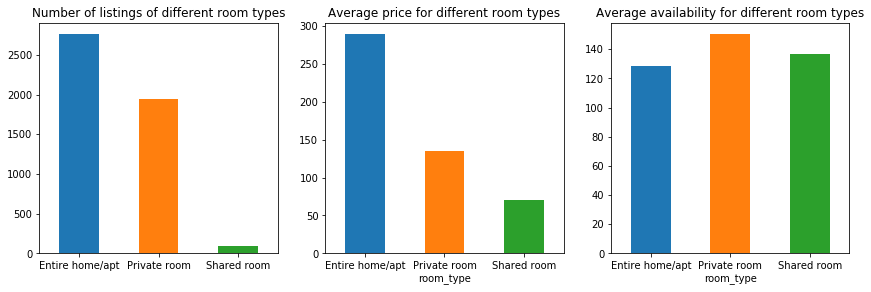

In [14]:
df_roomtype = df['room_type'].value_counts(dropna=False)
plt.subplot(1,3,1)
df_roomtype.plot(kind='bar',title = 'Number of listings of different room types', rot=0)
plt.subplot(1,3,2)
df.groupby('room_type')['price'].mean().plot(kind='bar', title = 'Average price for different room types', rot=0)
plt.subplot(1,3,3)
df.groupby('room_type')['availability_365'].mean().plot(kind='bar', title = 'Average availability for different room types', rot=0)
plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2, hspace=None)

### The plots above show that most people rent the entire home/apt out, and less people rent one of the rooms in their houses, and very few people share their rooms with strangers. The entire home types are most expensive, followed by private room and the shared rooms are the cheapest. The popularity are quite similar among different room types.

In [15]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

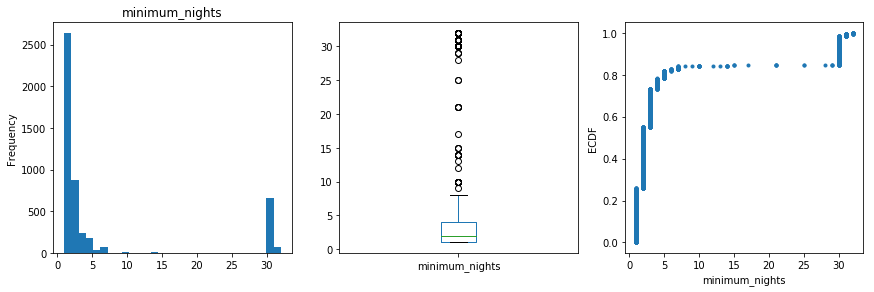

In [16]:
plt.subplot(1,3,1)
df_listing[df_listing.minimum_nights<50]['minimum_nights'].plot(kind='hist', bins=30, title = 'minimum_nights')

plt.subplot(1,3,2)
df_listing[df_listing['minimum_nights']<50]['minimum_nights'].plot(kind='box')

#Empirical Cumulative Distribution Function
x_mn, y_mn = ecdf(df_listing[df_listing.minimum_nights<50]['minimum_nights'])
plt.subplot(1,3,3)
plt.plot(x_mn, y_mn, marker = '.', linestyle = 'none')
plt.xlabel('minimum_nights')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

### The above plots show that most people did not require a minimum nights more than one night. And there are over 500 listings have requirements of a minimum night of 30 days. The listings with more than 30 day minimum night requirements are outliners.

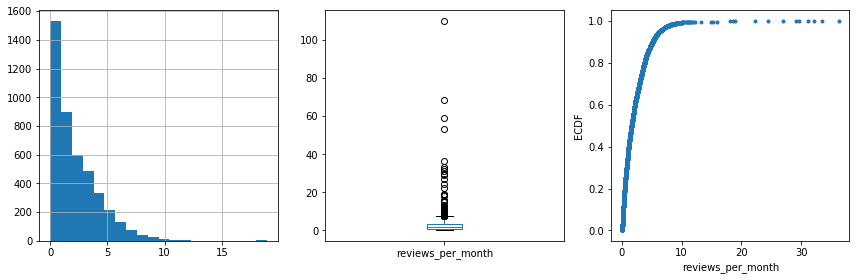

In [17]:
plt.subplot(1,3,1)
df_listing[df_listing.reviews_per_month<20]['reviews_per_month'].hist(bins=20)

plt.subplot(1,3,2)
df_listing['reviews_per_month'].plot(kind='box')

#Empirical Cumulative Distribution Function
x_rv, y_rv = ecdf(df_listing[df_listing.reviews_per_month <50]['reviews_per_month'])
plt.subplot(1,3,3)
plt.plot(x_rv, y_rv, marker = '.', linestyle = 'none')
plt.xlabel('reviews_per_month')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

### The plots show the listings with more than 10 reviews per month are outliers. And the listings with more than 30 reviews per month do not make sense and are impossible in reality.

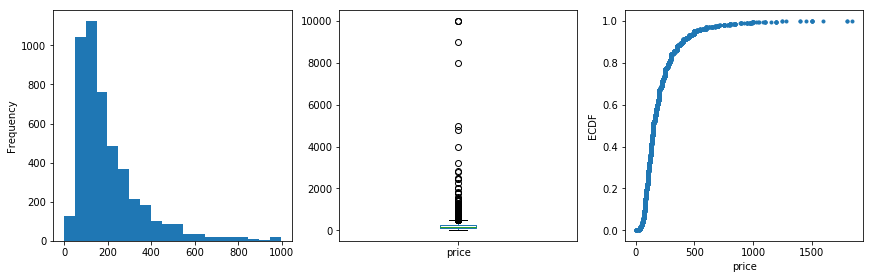

In [18]:
# Visualize the distribution of price
plt.subplot(1,3,1)
df[df['price']<1000]['price'].plot(kind='hist', bins=20)
plt.subplot(1,3,2)
df['price'].plot(kind='box')
#Empirical Cumulative Distribution Function
x_pr, y_pr = ecdf(df[df['price']<2000]['price'])
plt.subplot(1,3,3)
plt.plot(x_pr, y_pr, marker = '.', linestyle = 'none')
plt.xlabel('price')
plt.ylabel('ECDF')

plt.subplots_adjust(left=0.125, bottom=0.1, right=2, top=0.9, wspace=0.2)

In [19]:
df.price.median()

150.0

### The plots show that the prices of about 99% listings are under 1000 USD per night. The median price a night in SF is 150 USD. The listings with more than 1000 USD are outliers statistically but it does not necessarily mean these listings do not exit.

In [20]:
#Remove the dollar sign and convert the 'price' column to numeric dtype.
df_listing['price'] = df_listing.price.apply(lambda x: x.replace('$', ''))
df_listing['price'] = pd.to_numeric(df_listing['price'], errors='coerce')

In [21]:
import seaborn as sns

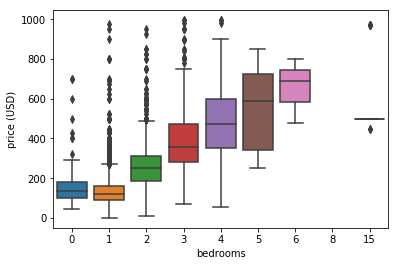

In [22]:
_ = sns.boxplot(x = 'bedrooms', y = 'price', data = df_listing)

# Label the axes
_ = plt.xlabel('bedrooms')
_ = plt.ylabel('price (USD)')

### The plot above shows that the more beds of a listing, the more expensive. There are only one listing with 15 bedrooms. There is not much difference between a one bedroom apt and a studio.

In [23]:
df_listing[(df_listing.reviews_per_month > 7) &(df_listing['availability_90'] <=5)].head(3)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
300,545685,https://www.airbnb.com/rooms/545685,20180303203625,2018-03-04,Garden Suite Private Bathrm GGPark,New renovated Garden Suite with separated entr...,Newly renovated Garden Suite with separated en...,New renovated Garden Suite with separated entr...,none,NaN,...,STR-0000234,"{""SAN FRANCISCO""}",f,t,moderate,f,f,2,7.85,POINT (-122.4823081405008 37.77619016624517)
372,713877,https://www.airbnb.com/rooms/713877,20180303203625,2018-03-04,Charming Cole Valley Private Suite,NaN,This lovely 1-bedroom suite in Cole Valley has...,This lovely 1-bedroom suite in Cole Valley has...,none,NaN,...,STR-0002074,"{""SAN FRANCISCO""}",t,t,moderate,f,f,1,15.85,POINT (-122.4530372750876 37.76369466514492)
1095,3257886,https://www.airbnb.com/rooms/3257886,20180303203625,2018-03-04,Golden Gate Park & Beach Getaway!,"Cozy 2BR flat with private entrance, 1 king be...",Sleeps 4 comfortably (1 king bed and 2 twins) ...,"Cozy 2BR flat with private entrance, 1 king be...",none,"Parkside, Oceanside jewel of San Francisco! A ...",...,City registration pending,"{""SAN FRANCISCO""}",t,f,moderate,f,f,1,7.21,POINT (-122.4977868172569 37.76390889746729)


##### Among the most popular listings in SF (shown by reviews_per_month greater than 7) and with availablity_90 less than 5 days, the listings either do not exit any more or the hosts actually blocked out a whole half a year or a year. However, there are many listings with zero reviews and they are fully booked in the next 90 days. This is because some hosts blacked out half a year or a whole year from their calendars, not because these listings are all sold out in the next 90 days. The common sense is you can still book your stay for even the most popular listings in three months.

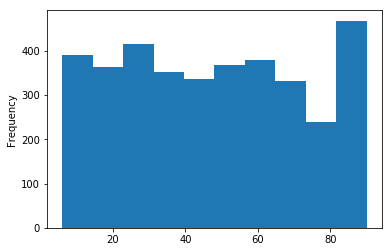

In [24]:
df_listing[df_listing['availability_90'] > 5]['availability_90'].plot(kind='hist',bins=10)

In [25]:
#Since there are blackout dates created by the hosts, I adjusted the dataframe by filtering the 'availability_90' greater than
#7 days to analyze factors related to the availability of the listings. 
df_clean = df_listing[(df_listing['availability_90'] > 5) & (df_listing['minimum_nights']<=60)]
df_clean.shape

(3637, 97)

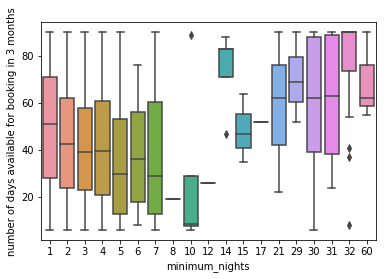

In [26]:
_ = sns.boxplot(x = 'minimum_nights', y = 'availability_90', data=df_clean)
# Label the axes
_ = plt.xlabel('minimum_nights')
_ = plt.ylabel('number of days available for booking in 3 months')
# Show the plot
plt.show()

### The plot above shows that listings with a minimum of more than 10 nights stay requirement are relatively less popular than those with less than 10 nights minimum stay. And among the listings with a less than a week of minimum nights stay requirement, the more minimum nights the host requires the guests to stay, the more popular the listing is. 

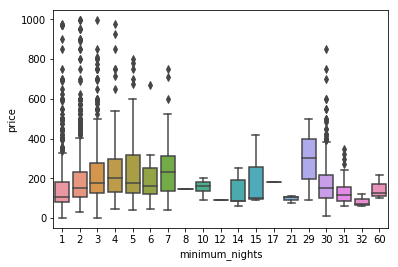

In [27]:
_ = sns.boxplot(x = 'minimum_nights', y = 'price', data=df_clean)
# Label the axes
_ = plt.xlabel('minimum_nights')
_ = plt.ylabel('price')
# Show the plot
plt.show()

### It seems there is no clear trend between the price and the minimum_nights requirements.

Text(0.5,1,'Cancellation policy')

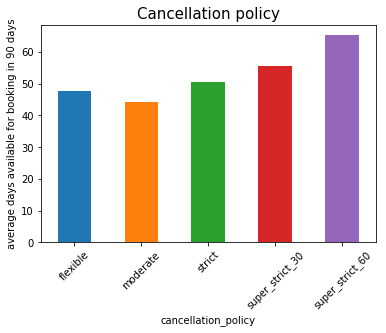

In [28]:
df_clean.groupby('cancellation_policy')['availability_90'].mean().plot(kind='bar', rot=45)
plt.ylabel('average days available for booking in 90 days')
plt.title('Cancellation policy', fontsize= 15)

### This plot shows that a flexible or strict cancellation policy does not significantly affect the popularity of a listing. A stricter cancellation policy decrease the booking rate a little bit. And setting a moderate cancellation policy helps with the booking rate.

Text(0.5,1,'Cancellation policy')

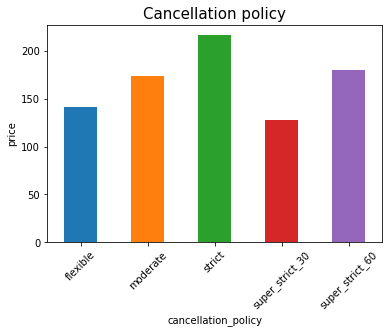

In [29]:
df_clean.groupby('cancellation_policy')['price'].mean().plot(kind='bar', rot=45)
plt.ylabel('price')
plt.title('Cancellation policy', fontsize= 15)

### The plot doesn't show a general trend, but among the flexible, moderate, and strict categories, the higher the price, the more strict of the cancellation plicy. 

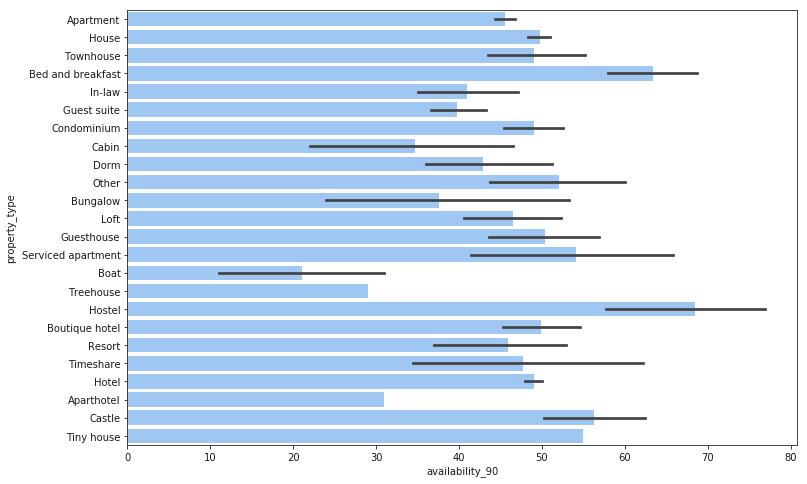

In [30]:
plt.figure(figsize=(12,8))
sns.set_color_codes('pastel')
sns.barplot(x='availability_90', y='property_type', data = df_clean, color="b")

### The barplot shows that the most popular property types are boat, treehouse, cabin and bungalow, which means unique and fancy properties are very attractive and having high occupancy rates.

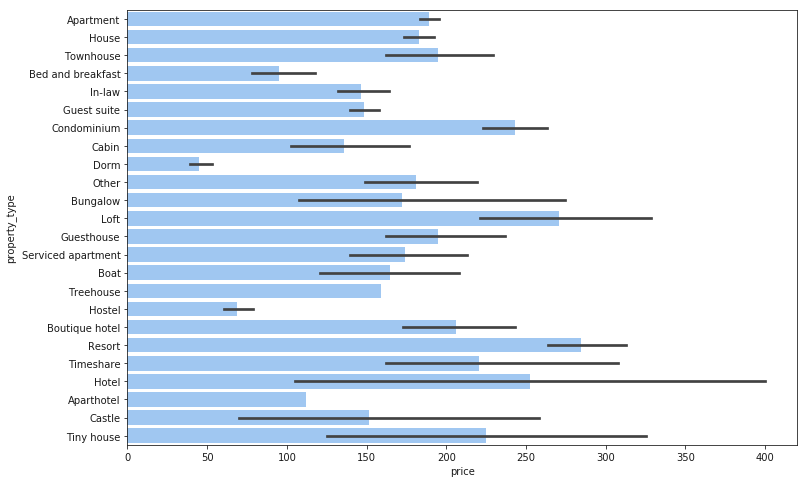

In [31]:
plt.figure(figsize=(12,8))
sns.set_color_codes('pastel')
sns.barplot(x='price', y='property_type', data = df_clean, color="b")

### In terms of price, the resort, loft, hotel and condo property types have the highest average prices, but the prices for hotel type listings have big variations.

In [32]:
file = '/Users/forheart/Dropbox/Data Scientist/Capstone Project 1/2018_march_reviews.csv'
df_review = pd.read_csv(file, sep=',')

In [33]:
df_review['date'] = pd.to_datetime(df_review['date'])
df_review['year'], df_review['month'] = df_review['date'].dt.year, df_review['date'].dt.month
df_review.head()

,listing_id,date,year,month
0,958,2009-07-23,2009,7
1,958,2009-08-03,2009,8
2,958,2009-09-27,2009,9
3,958,2009-11-05,2009,11
4,958,2010-02-13,2010,2


In [34]:
reviews_by_year = df_review['year'].value_counts()

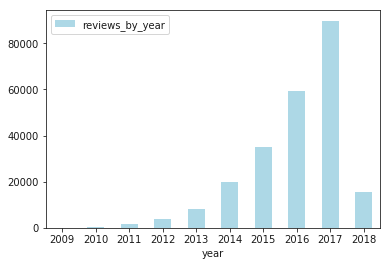

In [35]:
df1 = pd.DataFrame({'year': reviews_by_year.index, 'reviews_by_year': reviews_by_year.values})
df1 = df1.set_index('year').sort_index()
df1.plot(kind='bar', rot=0, color='lightblue')

### Airbnb stated in 2012 that 72% of guests leave reviews. So the reviews by year can represent the Airbnb stays increased a lot each year. This plot above shows the stays look like an exponential increase over the recent years, but still needs some regression to confirm that. When the data was scraped, it was still March in 2018. 

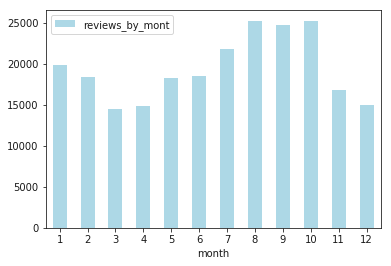

In [36]:
reviews_by_month = df_review['month'].value_counts()
df2 = pd.DataFrame({'month': reviews_by_month.index, 'reviews_by_mont': reviews_by_month.values})
df2 = df2.set_index('month').sort_index()
df2.plot(kind='bar', rot=0, color='lightblue')

### The plot above shows the seasonality of airbnb stays. The peak months are August, September and October, and the low seasons are March, April, November and December. 

In [37]:
df3 = df_clean[df_clean['neighbourhood'] == 'Mission District']

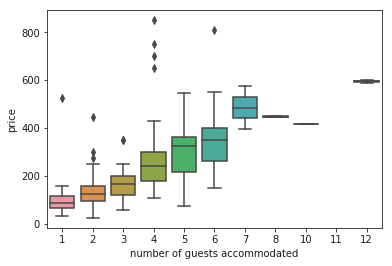

In [38]:
_ = sns.boxplot(x = 'accommodates', y = 'price', data=df3)
# Label the axes
_ = plt.xlabel('number of guests accommodated')
_ = plt.ylabel('price')
# Show the plot
plt.show()

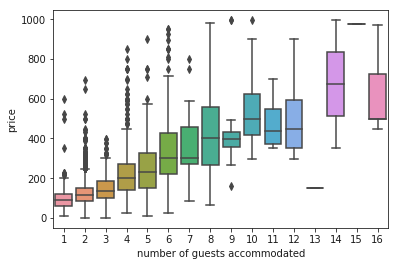

In [39]:
_ = sns.boxplot(x = 'accommodates', y = 'price', data=df_clean)
# Label the axes
_ = plt.xlabel('number of guests accommodated')
_ = plt.ylabel('price')
# Show the plot
plt.show()

In [40]:
df4 = df_clean[df_clean['neighbourhood'] == 'Bayview']
df5 = df_clean[df_clean['neighbourhood'] == 'North Beach']

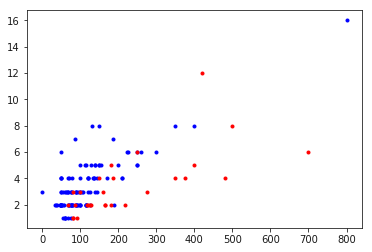

In [41]:
plt.plot(df4['price'], df4['accommodates'], marker='.', linestyle='none', color='blue')
plt.plot(df5['price'], df5['accommodates'], marker='.', linestyle='none', color='red')

### It is very hard to predict the availability or the popularity of the listings even when I restrict the dataframe to a certain neighbourhood and a certain capacity. It would be much easier to predict the reasonable price.

In [42]:
pd.Series(' '.join(df['name']).lower().split()).value_counts()[:40]

in           1276
private       824
room          703
with          526
the           498
bedroom       423
&             380
home          373
mission       366
victorian     357
sf            348
studio        320
modern        308
-             307
garden        306
of            274
sunny         271
spacious      263
2             250
apartment     247
bath          238
cozy          236
park          231
near          230
and           226
suite         225
flat          215
san           211
hill          186
valley        182
view          179
francisco     177
w/            175
views         175
heights       173
beautiful     171
to            171
house         168
heart         157
1             156
dtype: int64

### The top 10 desciptive words in the names of the listings are "private", "mission", "victorian", "modern", "garden", "sunny", "spacious", "cozy", and "view". 

In [43]:
df_popular = df_clean.sort_values(by=['reviews_per_month'], ascending=False)[:500]

In [44]:
pd.Series(' '.join(df_popular['name']).lower().split()).value_counts()[:40]

private      146
in           122
room          99
with          65
&             60
bath          56
suite         52
bedroom       48
cozy          46
studio        45
garden        45
-             40
the           40
near          39
parking       34
sf            33
mission       32
spacious      31
2             30
modern        29
and           29
victorian     28
park          26
w/            25
of            24
beach         23
free          22
1             20
san           20
charming      20
home          20
to            19
castro        19
a             18
apartment     18
ocean         17
francisco     16
gate          16
+             16
golden        16
dtype: int64

### The top 10 desciptive words in the names of the most popular listings (most reviewed) are "private", "cozy", "studio", "garden", "mission",  "spacious", "modern", "victorian", "beach", and "free".

In [45]:
df_expensive = df_clean.sort_values(by=['price'], ascending=False)[:500]

In [46]:
pd.Series(' '.join(df_expensive['name']).lower().split()).value_counts()[:40]

in           115
home          68
victorian     65
with          63
&             47
modern        47
the           43
sf            42
2             38
bedroom       38
flat          38
-             36
views         36
3             36
san           35
house         32
luxury        32
francisco     32
of            32
mission       31
sunny         30
beautiful     30
condo         29
view          28
w/            27
heights       26
spacious      26
hill          26
parking       25
valley        25
apartment     21
noe           21
private       20
location      20
castro        20
loft          19
and           18
soma          16
near          16
for           16
dtype: int64

### The top 10 desciptive words in the names of the most expensive 500 listings are "victorian", "modern", "views", "luxury", "mission",  "sunny", "beautiful", "spacious", "private", and "loft". We can tell the difference in the names of the most popular and most expensive listings reflects the difference in property characteristers in San Francisco.

In [47]:
url_cal='http://data.insideairbnb.com/united-states/ca/san-francisco/2018-03-04/data/calendar.csv.gz'
df_cal = pd.read_csv(url_cal, sep=',')

In [62]:
df_cal.head()

,listing_id,date,available,price,day_of_week
0,6938818,2019-03-03,f,NaN,Sunday
1,6938818,2019-03-02,f,NaN,Saturday
2,6938818,2019-03-01,f,NaN,Friday
3,6938818,2019-02-28,f,NaN,Thursday
4,6938818,2019-02-27,f,NaN,Wednesday


In [49]:
df_cal['date'] = pd.to_datetime(df_cal['date'])

In [50]:
df_cal['day_of_week'] = df_cal['date'].dt.weekday_name

In [63]:
df_booking = df_cal[df_cal['available'] == 't']

In [67]:
df_booking.head()

,listing_id,date,available,price,day_of_week
29,6938818,2018-11-11,t,$69.00,Sunday
30,6938818,2018-11-10,t,$69.00,Saturday
31,6938818,2018-11-09,t,$69.00,Friday
32,6938818,2018-11-08,t,$69.00,Thursday
33,6938818,2018-11-07,t,$69.00,Wednesday


In [72]:
df_booking['day_of_week'].value_counts()

Sunday       95235
Tuesday      95101
Monday       95071
Wednesday    94721
Thursday     93977
Saturday     93473
Friday       93253
Name: day_of_week, dtype: int64

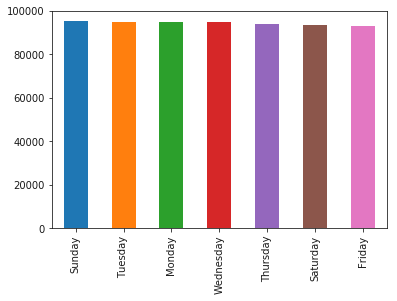

In [73]:
df_booking['day_of_week'].value_counts().plot(kind='bar')

### There is not a big difference between weekend and weekday bookings. In the next year's booking calendar, the most bookings are on Friday, followed by Saturday, Thursday, Wednesday, Monday, Tuesday, and Sunday.